In [1]:
import matplotlib
#matplotlib.use('Agg')
import sys
sys.path.append('/Users/nw/Uni/tss18-robotsinmusicalimprovisation/')
import numpy as np
import glob
import pypianoroll as ppr
import time
import music21
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from utils.utilsPreprocessing import *
#np.set_printoptions(threshold=np.inf)
#torch.set_printoptions(threshold=50000)

In [2]:
############HYPERPARAMS#####################
epochs = 300
learning_rate = 1e-3
batch_size = 100 #CHANGE THIS VERWRIRUNG
seq_length = 8
log_interval = 100 #Log/show loss per batch
input_size = 100
############LSTM PARAMS#####################
hidden_size = 16
lstm_layers = 2
############################################
############################################
batch_loader = batch_size*seq_length

In [3]:
def createDataset(dataset, seq_length = 8, shuffle=True):    
    inputs = []
    gts = []
    data = []
    
    input_curr = []
    gt_current = []
    
    for k in range(0, len(dataset)-seq_length):
        data.append(dataset[k:k+seq_length])
    
    # permutation
    if(shuffle):
        np.random.seed(345)
        per = np.random.permutation(len(data))
        data = [data[i] for i in per]

    return np.array(data)

In [4]:
#load variational autoencoder
from utils.VAE import VAE
from loadModel import loadModel, loadStateDict
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###VARIATIONAL CONV AUTOENCODER############
autoencoder_model = VAE()
path_to_model = '../../new_models_and_plots/YamahaPC2002_VAE_Reconstruct_NoTW_20Epochs.model'
###########################################

autoencoder_model = loadModel(autoencoder_model, path_to_model, dataParallelModel=False)
#autoencoder_model = loadStateDict(autoencoder_model, path_to_model)
autoencoder_model = autoencoder_model.to(device)


--------GPU model restored--------



In [5]:
#load dataset from npz
data = np.load('../../WikifoniaPartlyNoTranspose.npz')
train_dataset = data['train']
test_dataset = data['test']
data.close()

print(train_dataset.shape)
print(test_dataset.shape)

(4056, 1, 96, 60)
(1034, 1, 96, 60)


In [6]:
#only possible if data was pre-encoded
#train_dataset = createDataset(train_dataset, seq_length = seq_length)
#test_dataset = createDataset(test_dataset, seq_length = seq_length)

In [7]:
#train_dataset = train_dataset[0:1000]
train_dataset = torch.from_numpy(train_dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_loader, shuffle=False, drop_last=True)

#test_dataset = test_dataset[0:100]
test_dataset = torch.from_numpy(test_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_loader, shuffle=False, drop_last=True)

print(train_dataset.size())
print(test_dataset.size())

torch.Size([4056, 1, 96, 60])
torch.Size([1034, 1, 96, 60])


In [8]:
class LSTM(nn.Module):
    def __init__(self, batch_size=7, lstm_layers=2, hidden_size=32, seq_length=7, input_size=100):
        super(LSTM, self).__init__()
        
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.lstm_layers = lstm_layers
        self.seq_length = seq_length
        self.input_size = input_size
        
        ###LSTM###########
        self.lstm = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size,
                            num_layers=self.lstm_layers, batch_first=True, dropout=0.3)
        ##################
        
        ###LINEAR LAYERS###
        self.i2h = nn.Linear(self.input_size, self.hidden_size)
        self.h2o = nn.Linear(self.hidden_size,self.input_size)
        ###################

        ###LSTMCells######
        #self.lstmC1 = nn.LSTMCell(input_size=self.input_size, hidden_size=self.hidden_size, bias=True)
        #self.drop1 = nn.Dropout(p=0.1)
        #self.lstmC2 = nn.LSTMCell(input_size=self.hidden_size, hidden_size=self.hidden_size, bias=True)
        #self.drop2 = nn.Dropout(p=0.2)
        #self.lstmC3 = nn.LSTMCell(input_size=self.hidden_size, hidden_size=self.hidden_size, bias=True)
        #################      
    
    def reorder_batch(self, embedded_seqs):
        return torch.stack(torch.chunk(embedded_seqs, int(self.batch_size/self.seq_length)))
         
    def hidden_init(self):
        return torch.zeros(self.lstm_layers, int(self.batch_size/self.seq_length), 
                           self.hidden_size, dtype=torch.double).to(device)

    def forward(self, embed, future = 0):#, lenghts):
        h_t0 = self.hidden_init()
        c_t0 = self.hidden_init()
        
        lstm_input = self.i2h(embed)
        output, (h_t1, c_t1) = self.lstm(lstm_input, (h_t0, c_t0))
        output = self.h2o(output[:,:,:])
        
        """
        (h_t, c_t),(h2_t, c2_t),(h3_t,c3_t)= self.hiddenInitLSTMCell()

        outputs = []
        for i in range(0,self.seq_length-1):
            h_t, c_t = self.lstmC1(embed[:,i,:],(h_t, c_t))
            h2_t, c2_t = self.lstmC2(h_t,(h2_t, c2_t))
            h3_t, c3_t = self.lstmC3(h2_t,(h3_t, c3_t))
            output = self.fc(h3_t)
            #outputs += [output]
            
        
        for i in range(future):
            h_t, c_t = self.lstmC1(output,(h_t, c_t))
            h2_t, c2_t = self.lstmC2(h_t, (h2_t, c2_t))
            h3_t, c3_t = self.lstmC3(h2_t,(h3_t, c3_t))
            output = self.fc(h3_t)
            #outputs += [output]
        
        #outputs = torch.stack(outputs, 1)
        """
        return embed, output
    

model = LSTM(batch_size=batch_loader, seq_length=seq_length, 
             input_size=input_size, hidden_size=hidden_size,
             lstm_layers = lstm_layers).double().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(model.parameters(),lr=learning_rate, momentum=0.9)


def train(epoch):
    model.train()
    train_loss = 0
    criterion = nn.MSELoss()
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        #float byte tensor
        data = data.float().to(device)
        #embed data with autoencoder
        with torch.no_grad():
            mu, logvar = autoencoder_model.encoder(data)
        
        #prepare for input lstm
        embedding = model.reorder_batch(mu)
        embedding = embedding.double()
        
        #Normalize to mean 0 and std 1
        #mean_batch = torch.mean(embedding)
        #std_batch = torch.std(embedding)
        #embedding_norm = (embedding - mean_batch) / std_batch
        
        g_truth = embedding[:,1:,:]
        input_lstm = embedding[:,:-1,:]
        _ , output_lstm = model(input_lstm, future = 0)

        loss = criterion(output_lstm, g_truth)
        loss.backward()
        train_loss += loss.item()
        
        optimizer.step()
        if(batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()))# / (len(data)-(model.batch_size/model.seq_length))))
            print('ground_truth');print(g_truth.size());print(g_truth[:2,15:30])
            print('output_lstm');print(output_lstm.size());print(output_lstm[:2,15:30])
    
    print('====> Epoch: {} Average Loss: {:.4f}'.format(
          epoch, train_loss/(batch_idx+1)))# / (len(trainLoader.dataset)-batch_idx*(model.batch_size/model.seq_length))))
    print('\n\n')
    return train_loss/(batch_idx+1)
    
def test(epoch):
    model.eval()
    test_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.float().to(device)
            mu, logvar = autoencoder_model.encoder(data)
            
            #prepare for input lstm
            embedding = model.reorder_batch(mu)
            embedding = embedding.double()

            #Normalize to mean 0 and std 1
            #mean_batch = torch.mean(embedding)
            #std_batch = torch.std(embedding)
            #embedding_norm = (embedding - mean_batch) / std_batch

            g_truth = embedding[:,1:,:]
            input_lstm = embedding[:,:-1,:]
            _ , output_lstm = model(input_lstm, future = 0)

            test_loss += criterion(output_lstm, g_truth).item()

    test_loss /= (i+1)
    print('ground_truth');print(g_truth.size());print(g_truth[:,15:30])
    print('output_lstm');print(output_lstm.size());print(output_lstm[:,15:30])

    print('====> Test set Loss: {:.4f}'.format(test_loss))
    return test_loss

Train Epoch: 1 [0/4056 (0%)]	Loss: 3.324170
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 1 Average Loss: 3.3513



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 3.3967
Train Epoch: 2 [0/4056 (0%)]	Loss: 3.295784
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 2 Average Loss: 3.3220



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 3.3643
Train Epoch: 3 [0/4056 (0%)]	Loss: 3.266690
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], 

ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.6131
Train Epoch: 21 [0/4056 (0%)]	Loss: 2.569387
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 21 Average Loss: 2.5908



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.6064
Train Epoch: 22 [0/4056 (0%)]	Loss: 2.561296
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 22 Average Loss: 2.5854



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss

====> Epoch: 40 Average Loss: 2.5531



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5748
Train Epoch: 41 [0/4056 (0%)]	Loss: 2.517304
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 41 Average Loss: 2.5527



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5744
Train Epoch: 42 [0/4056 (0%)]	Loss: 2.517284
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 42 Average Loss: 2.5522



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], 

====> Epoch: 60 Average Loss: 2.5470



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5695
Train Epoch: 61 [0/4056 (0%)]	Loss: 2.509107
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 61 Average Loss: 2.5465



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5692
Train Epoch: 62 [0/4056 (0%)]	Loss: 2.508822
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 62 Average Loss: 2.5454



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], 

====> Epoch: 80 Average Loss: 2.5318



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5612
Train Epoch: 81 [0/4056 (0%)]	Loss: 2.491595
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 81 Average Loss: 2.5303



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5610
Train Epoch: 82 [0/4056 (0%)]	Loss: 2.491795
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 82 Average Loss: 2.5292



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], 

====> Epoch: 100 Average Loss: 2.5035



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5523
Train Epoch: 101 [0/4056 (0%)]	Loss: 2.455760
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 101 Average Loss: 2.5023



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5501
Train Epoch: 102 [0/4056 (0%)]	Loss: 2.454098
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 102 Average Loss: 2.5002



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor

Train Epoch: 120 [0/4056 (0%)]	Loss: 2.427879
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 120 Average Loss: 2.4763



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5333
Train Epoch: 121 [0/4056 (0%)]	Loss: 2.431413
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 121 Average Loss: 2.4760



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5325
Train Epoch: 122 [0/4056 (0%)]	Loss: 2.428213
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
t

====> Epoch: 139 Average Loss: 2.4602



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5288
Train Epoch: 140 [0/4056 (0%)]	Loss: 2.413188
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 140 Average Loss: 2.4616



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5280
Train Epoch: 141 [0/4056 (0%)]	Loss: 2.413530
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 141 Average Loss: 2.4606



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor

Train Epoch: 159 [0/4056 (0%)]	Loss: 2.397770
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 159 Average Loss: 2.4468



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5267
Train Epoch: 160 [0/4056 (0%)]	Loss: 2.402501
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 160 Average Loss: 2.4470



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5268
Train Epoch: 161 [0/4056 (0%)]	Loss: 2.400606
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
t

====> Epoch: 178 Average Loss: 2.4357



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5256
Train Epoch: 179 [0/4056 (0%)]	Loss: 2.390265
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 179 Average Loss: 2.4345



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5260
Train Epoch: 180 [0/4056 (0%)]	Loss: 2.390025
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 180 Average Loss: 2.4340



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor

Train Epoch: 198 [0/4056 (0%)]	Loss: 2.376596
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 198 Average Loss: 2.4191



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5246
Train Epoch: 199 [0/4056 (0%)]	Loss: 2.372675
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 199 Average Loss: 2.4170



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5231
Train Epoch: 200 [0/4056 (0%)]	Loss: 2.367589
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
t

====> Epoch: 217 Average Loss: 2.4045



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5222
Train Epoch: 218 [0/4056 (0%)]	Loss: 2.355604
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 218 Average Loss: 2.4039



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5232
Train Epoch: 219 [0/4056 (0%)]	Loss: 2.349770
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 219 Average Loss: 2.4036



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor

Train Epoch: 237 [0/4056 (0%)]	Loss: 2.338269
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 237 Average Loss: 2.3888



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5193
Train Epoch: 238 [0/4056 (0%)]	Loss: 2.335506
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 238 Average Loss: 2.3899



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5214
Train Epoch: 239 [0/4056 (0%)]	Loss: 2.335505
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
t

====> Epoch: 256 Average Loss: 2.3790



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5220
Train Epoch: 257 [0/4056 (0%)]	Loss: 2.317566
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 257 Average Loss: 2.3804



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5201
Train Epoch: 258 [0/4056 (0%)]	Loss: 2.323679
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 258 Average Loss: 2.3813



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor

Train Epoch: 276 [0/4056 (0%)]	Loss: 2.305224
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 276 Average Loss: 2.3704



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5233
Train Epoch: 277 [0/4056 (0%)]	Loss: 2.308450
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 277 Average Loss: 2.3685



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5227
Train Epoch: 278 [0/4056 (0%)]	Loss: 2.304551
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
t

====> Epoch: 295 Average Loss: 2.3582



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5247
Train Epoch: 296 [0/4056 (0%)]	Loss: 2.293960
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 296 Average Loss: 2.3594



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
====> Test set Loss: 2.5247
Train Epoch: 297 [0/4056 (0%)]	Loss: 2.293349
ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)
====> Epoch: 297 Average Loss: 2.3598



ground_truth
torch.Size([100, 7, 100])
tensor([], dtype=torch.float64)
output_lstm
torch.Size([100, 7, 100])
tensor

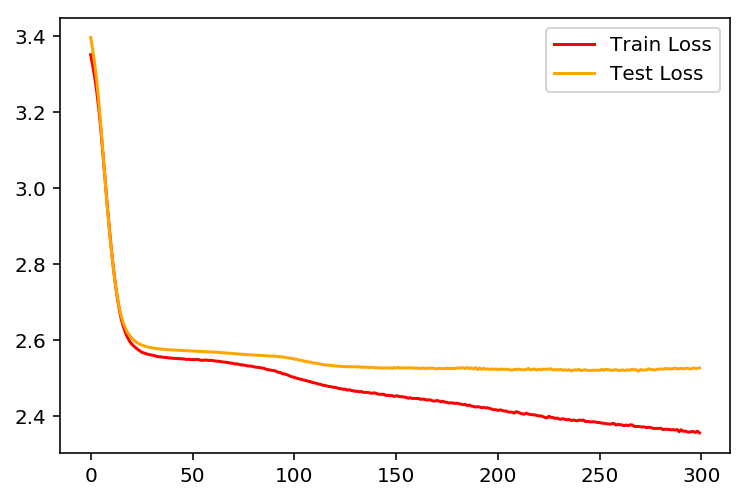

In [9]:
#import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

train_losses = []
test_losses = []
best_test_loss = np.inf

for epoch in range(1, epochs + 1):
    train_losses.append(train(epoch))
    
    current_test_loss = test(epoch)
    test_losses.append(current_test_loss)
#     if(current_test_loss < best_test_loss):
#         best_test_loss = current_test_loss
#         torch.save(model,'/media/EXTHD/niciData/models/LSTM_YamahaPCNoTP_' + str(hidden_size) + 'hidden_50epochs.model')
    
plt.plot(train_losses, color='red', label='Train Loss')
plt.plot(test_losses, color='orange', label='Test Loss')
plt.legend()
plt.savefig('../plots/LSTM_WikifoniaNoTP_'+str(hidden_size)+'hidden' + str(epochs) +'epoch_Many2Many.png')
plt.show()